# **Pattern Matching using Grover's Algorithm**

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from BoredQiskit import FastQiskit as fq
from BoredQiskit import FastOracles as fo
from BoredQiskit.FastUtilsGate import int_to_bin
import numpy as np

In [2]:
def grover_operator(n: int):
    '''
    builds the diffusion operator from the grover algorithm
    '''
    qx = QuantumRegister(n, 'x')
    qc = QuantumCircuit(qx)
    
    qc.h(qx)
    qc.x(qx)
    qc.h(qx[n-1])
    qc.mcx(qx[list(range(n-1))], qx[n-1])
    qc.h(qx[n-1])
    qc.x(qx)
    qc.h(qx)

    return qc.to_gate(label='DIFFUSION')


In [3]:
def encode_boolean_string(x: str):
    '''
    encodes a boolean string in a quantum circuit using x gates
    '''
    n = len(x)
    qx = QuantumRegister(n, 'x')
    qc = QuantumCircuit(qx)

    for c, i in enumerate(x):
        if i == '1':
            qc.x(qx[n - c - 1])
    
    return qc


In [4]:
def _quantum_rotation(n: int, s: int):
    '''
    Returns a `.Gate` that implements a rotation
    of `s` positions on `n` qubits lines.
    
    Only works correctly if `s` is a power of 2. Every other
    rotation can be obtained by combination of the power of 2 rotations; so

    DONT USE THIS !!!
    '''
    qr = QuantumRegister(n, 'q')
    qc = QuantumCircuit(qr)
    
    for i in range(1, int(np.ceil(n/2))):
        qc.swap(qr[i], qr[n-i])
    
    for j in range(1, int(np.ceil(n/2))):
        qc.swap(qr[int(np.ceil(s/2))-j], qr[int(np.floor(s/2))+j])

    return qc.to_gate(label='R_'+str(s)+' ')


def quantum_controlled_rotation(n: int):
    '''
    Returns an arbitrary rotation `.Gate` on `n` qubits lines.

    page 9 of the paper
    '''
    l = np.log2(n)
    l = int(np.ceil(l))

    jr = QuantumRegister(l, 'j')
    qr = QuantumRegister(n, 'q')

    qc = QuantumCircuit(jr, qr)
    for i in range(l):
        
        qc = qc.compose(_quantum_rotation(n, 2**i).control(1), [i,*qr])
    return qc.to_gate(label='ROT')


In [5]:
def is_equal_oracle(n: int):
    '''
    returns a boolean oracle that checks if two given strings of length `n`
    are identical.
    '''
    qx = QuantumRegister(n, 'x')
    qy = QuantumRegister(n, 'y')
    a = QuantumRegister(1, 'a')
    
    qc = QuantumCircuit(qx, qy, a)

    for i in range(n):
        qc.cx(qx[i], qy[i])
        
    qc.x(qy)
    qc.mcx([*qy], a)
    qc.x(qy)

    for i in range(n):
        qc.cx(qx[i], qy[i])

    return qc.to_gate(label=' is equal ')


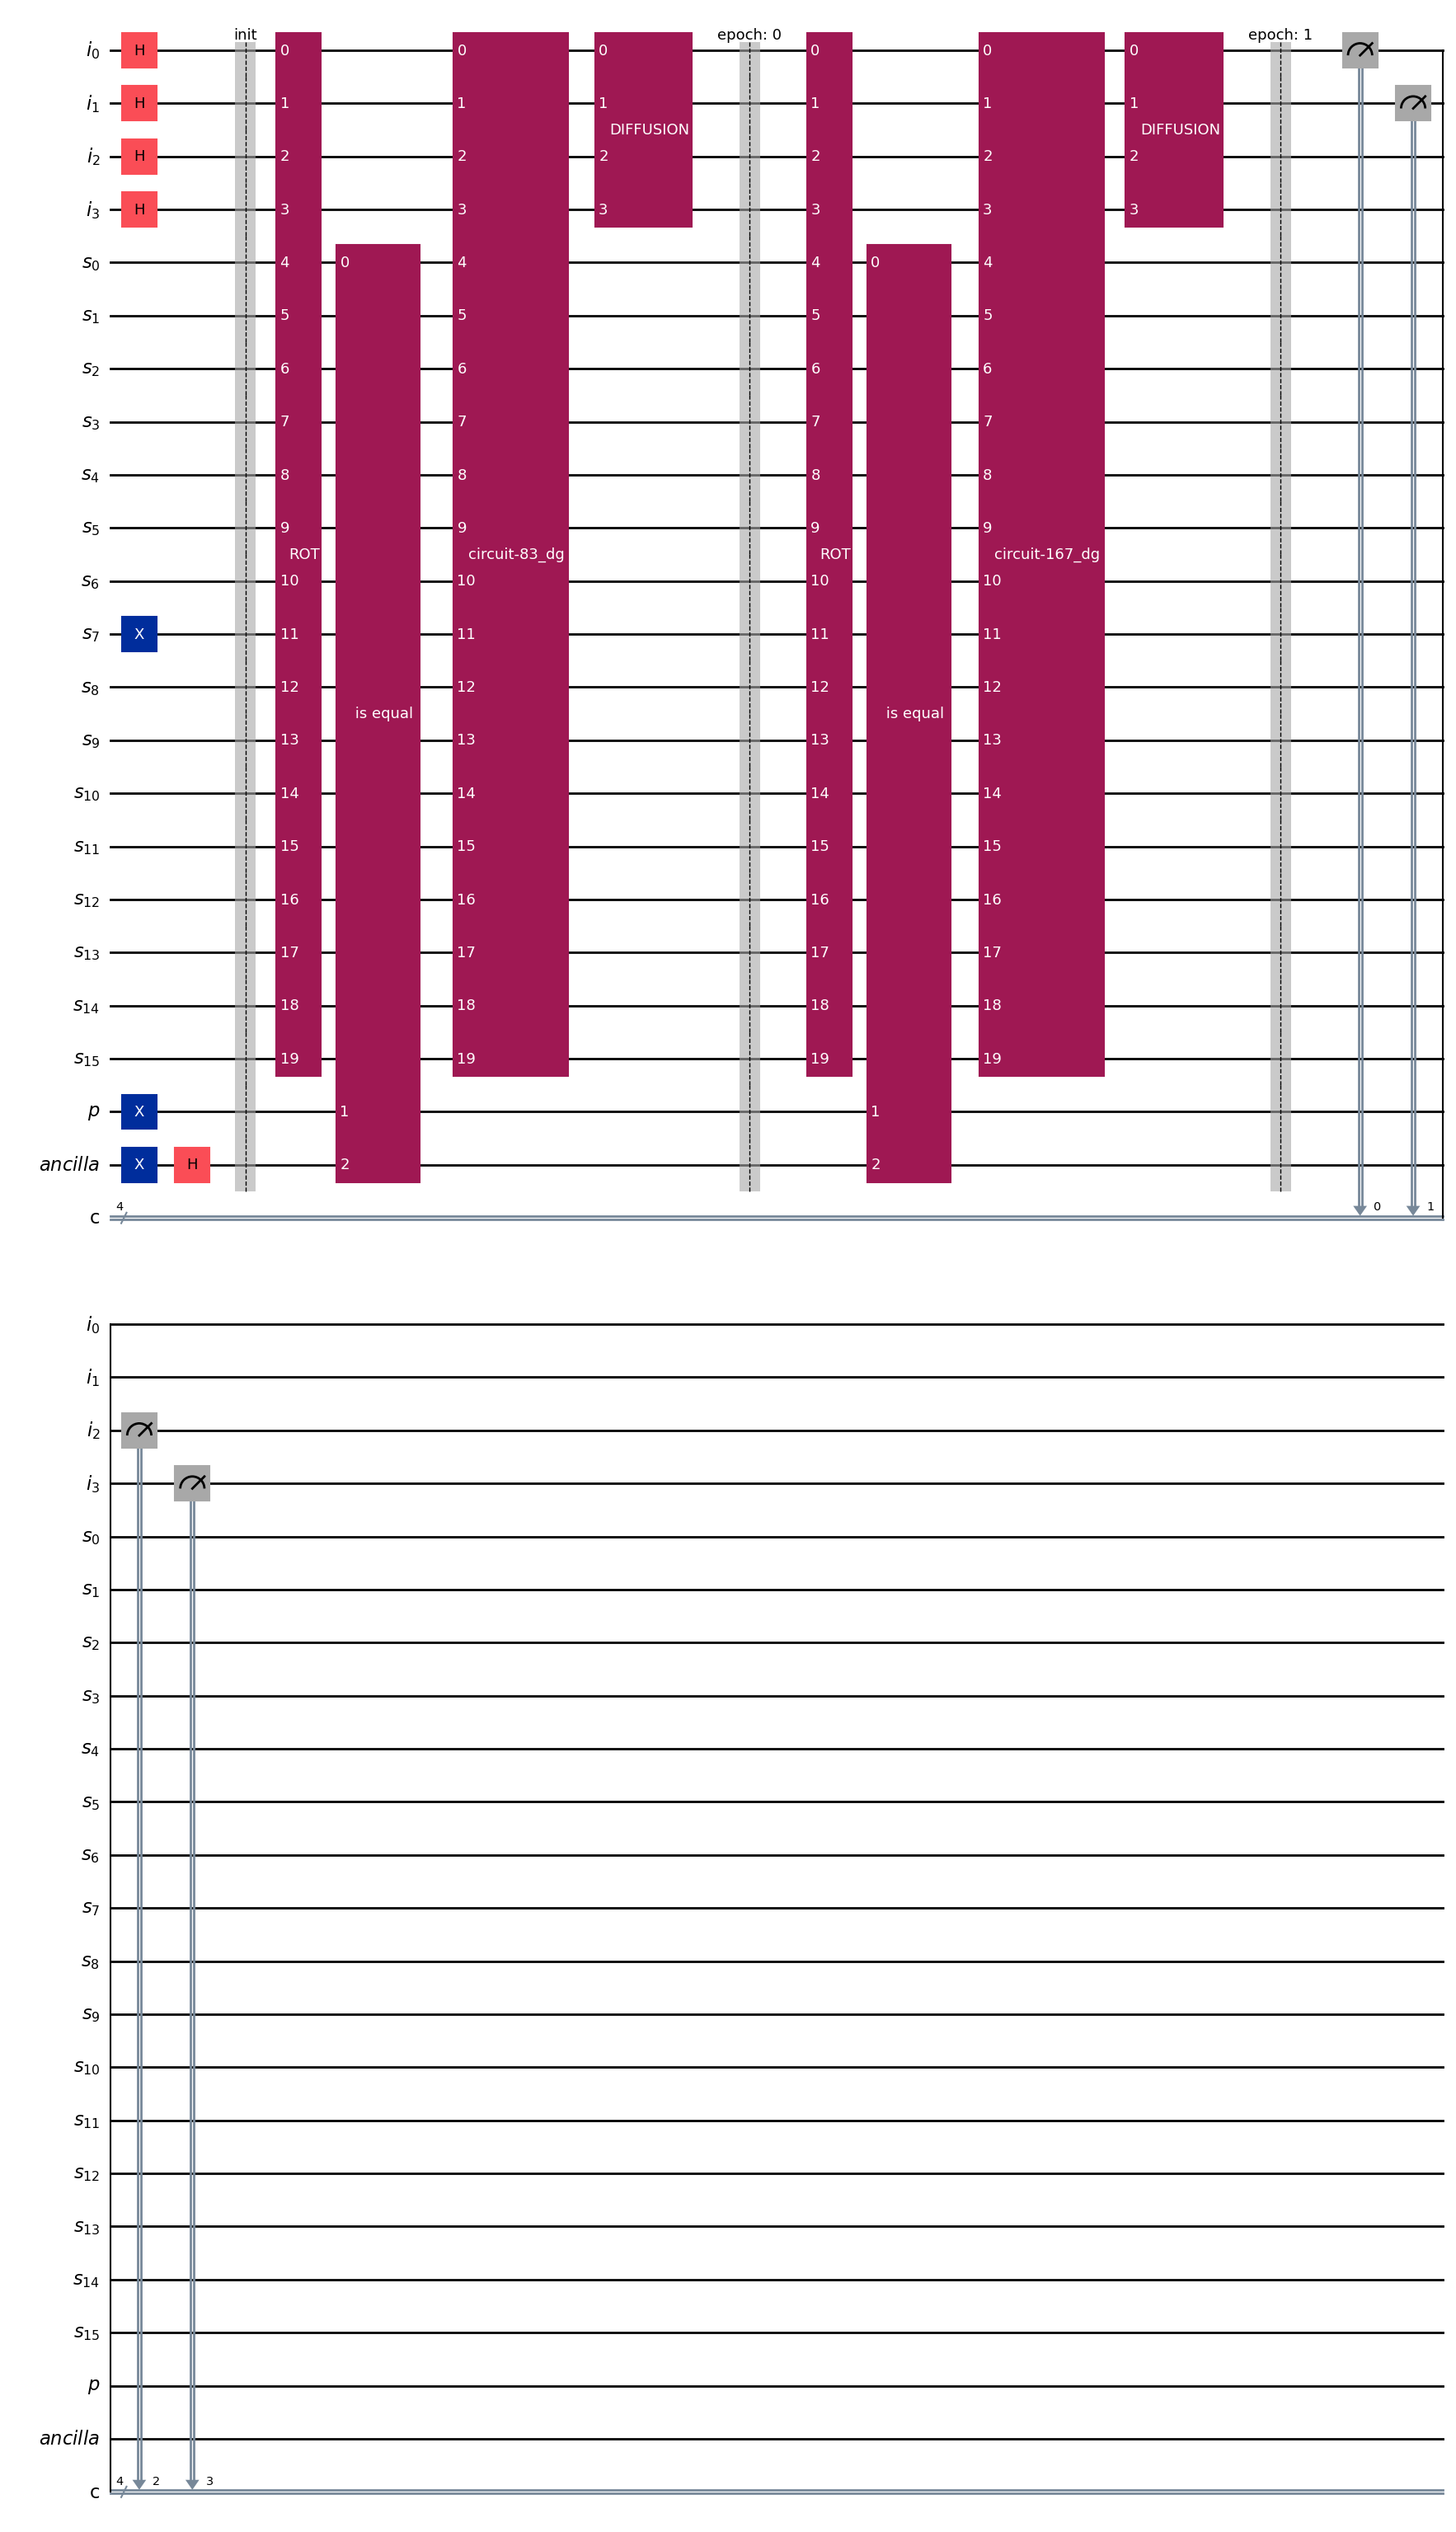

In [ ]:
def grover_pattern_matching(S: str, P: str, epochs: int):

    n = len(S)
    m = len(P)
    I = int(np.ceil(np.log2(n)))

    qi = QuantumRegister(I, 'i')
    qs = QuantumRegister(n, 's')
    qp = QuantumRegister(m, 'p')
    a = QuantumRegister(1, 'ancilla')

    c = ClassicalRegister(I, 'c')

    qc = QuantumCircuit(qi, qs, qp, a, c)

    qc.x(a)
    qc.h(a)

    qc.h(qi)

    qc = qc.compose(encode_boolean_string(S), qs)

    qc = qc.compose(encode_boolean_string(P), qp)

    qc.barrier(label='init')

    for e in range(epochs):
        qc = qc.compose(quantum_controlled_rotation(n), [*qi, *qs])

        qc = qc.compose(is_equal_oracle(m), [*qs[:m], *qp, a])

        qc = qc.compose(quantum_controlled_rotation(n).inverse(), [*qi, *qs])

        qc = qc.compose(grover_operator(I), qi)

        qc.barrier(label=f'epoch: {e}')

    qc.measure(qi, c)

    return qc

S = '0000100'
n = len(S)
P = '001'
m = len(P)
I = int(np.ceil(np.log2(n)))
epochs = 2

qc = grover_pattern_matching(S, P, epochs)
qc.draw('mpl')

In [7]:
fq.run(qc)

{'1111': 74,
 '0001': 57,
 '1011': 58,
 '1100': 56,
 '1101': 48,
 '0100': 74,
 '0000': 56,
 '1000': 78,
 '1110': 68,
 '1001': 64,
 '0111': 68,
 '0101': 75,
 '0110': 64,
 '0010': 67,
 '1010': 63,
 '0011': 54}